# Imports 

In [1]:
# %% Imports y configuración
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agregar el directorio raíz al path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

from model_dpm.simulations.sim_mixture import multimodal_mixture_sampler
from model_dpm.utils.sistem_fun import load_config, get_data_path, get_report_path
from model_dpm.models.kernel_normal_v2 import DPMNormal
from model_dpm.graphics.density import plot_density_estimation
from model_dpm.graphics.diagnostic import plot_cluster_assignment, plot_cluster_densities, plot_traces
from model_dpm.graphics.app_1 import plot_density_credible_interval
from model_dpm.utils.sistem_regist import register_experiment
from model_dpm.utils.sistem_artefact import save_artifact

config=load_config()

# Configuracion

In [2]:
# %% Parámetros de ejecución
NOMBRE_EJECUCION = "kernel_normal_001"
SIM_REAL = "simulation"
CARACTERISTICAS = "Primera prueba del modelo DPM con kernel normal - datos simulados con mixture de Laplace y Normal"

print(f"📊 Ejecución: {NOMBRE_EJECUCION}")
print(f"📁 Tipo: {SIM_REAL}")
print(f"📝 Notas: {CARACTERISTICAS}")

# Registrar experimento
experiment_id = register_experiment(
    config=config,
    run_name=NOMBRE_EJECUCION,
    experiment_type=SIM_REAL,
    description=CARACTERISTICAS
)

# Persistir ID del experimento en la configuración en memoria
config["current_experiment"]["id"] = experiment_id
config["current_experiment"]["type"] = SIM_REAL
config["current_experiment"]["description"] = CARACTERISTICAS

📊 Ejecución: kernel_normal_001
📁 Tipo: simulation
📝 Notas: Primera prueba del modelo DPM con kernel normal - datos simulados con mixture de Laplace y Normal
✅ Experimento registrado: v2.0.0_kernel_normal_001_20251222_235558
📁 Registry: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\model_dpm\..\versioning\experiment_registry.md


# Simulacion 

In [3]:
##################################################
# Simulacion o data real
##################################################

# Definir los parámetros de cada componente
components = [
    {'type': 'laplace', 'loc': -10, 'scale': 0.5, 'size': 100},
    {'type': 'laplace', 'loc': 30, 'scale': 0.5, 'size': 100},
    {'type': 'normal', 'loc': -10, 'scale': 0.8, 'size': 100},
    {'type': 'normal', 'loc': 30, 'scale': 0.8, 'size': 100}
]

print("\n🎲 Generando datos simulados...")
datos_array  = multimodal_mixture_sampler(components)

print(f"✅ Datos generados: {len(datos_array)} observaciones")

# Convertir a DataFrame si es necesario
if isinstance(datos_array, np.ndarray):
    datos = pd.DataFrame({'value': datos_array})
else:
    datos = datos_array

print(f"✅ Datos generados: {len(datos)} observaciones")
print(f"📊 Estadísticas descriptivas:")
print(datos.describe())

##################################################
# Guardar datos 
##################################################
output_path = get_data_path(config, data_type=SIM_REAL, io_type="output")
output_path.mkdir(parents=True, exist_ok=True)

datos_file = output_path / f"{NOMBRE_EJECUCION}.csv"
datos.to_csv(datos_file, index=False)
print(f"\n💾 Datos guardados en: {datos_file}")


🎲 Generando datos simulados...
✅ Datos generados: 400 observaciones
✅ Datos generados: 400 observaciones
📊 Estadísticas descriptivas:
            value
count  400.000000
mean     9.960375
std     19.982460
min    -11.736212
25%    -10.013742
50%      9.825647
75%     29.935662
max     33.025889

💾 Datos guardados en: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\data\simulaciones\kernel_normal_001.csv


# DPM

In [4]:
##################################################
# Aplicar la clase del modelo
##################################################

# %% Inicializar y ajustar modelo
print("\n🔧 Inicializando modelo DPM con kernel normal...")

# Crear instancia del modelo
model = DPMNormal(
    y=datos['value'].values,
    H=20,                             # Truncamiento inicial
    M_prior=(2.0, 1.0),               # Prior para concentración
    mu0_prior=(0.0, 10.0),            # Prior para μ₀
    kappa0_prior=(1.0, 1.0),          # Prior para κ₀
    a0_prior=(2.0, 1.0),              # Prior para a₀
    b0_prior=(2.0, 1.0),              # Prior para b₀
    verbose=True
)

# Ajustar el modelo
print("🔄 Ajustando modelo con Slice Sampling ...")
trace = model.run(iterations=200, burnin=50)

print("✅ Modelo ajustado exitosamente")

##################################################
# Guardar clase
##################################################

# Guardar trace
trace_path = save_artifact(
    config=config,
    experiment_id=experiment_id,
    artifact=trace,
    artifact_name="trace",
    data_type=SIM_REAL
)

# Guardar modelo completo
model_path = save_artifact(
    config=config,
    experiment_id=experiment_id,
    artifact=model,
    artifact_name="model",
    data_type=SIM_REAL
)

print("✅ Modelo Guardado exitosamente")


🔧 Inicializando modelo DPM con kernel normal...
🔄 Ajustando modelo con Slice Sampling ...
Iter 100/200: K_eff=2, M=0.61, μ₀=0.54, κ₀=0.02, a₀=8.03, b₀=0.07 [Acc: κ=0.83, a=0.67]
Iter 200/200: K_eff=2, M=0.22, μ₀=-0.43, κ₀=0.01, a₀=2.02, b₀=0.03 [Acc: κ=0.83, a=0.84]
✅ Modelo ajustado exitosamente
✅ Artefacto 'trace' guardado
📁 Ruta: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\artefact\simulaciones\models\v2.0.0_kernel_normal_001_20251222_235558_trace.pkl
✅ Artefacto 'model' guardado
📁 Ruta: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\artefact\simulaciones\models\v2.0.0_kernel_normal_001_20251222_235558_model.pkl
✅ Modelo Guardado exitosamente


# Graficos 

In [5]:
##################################################
# Resultados exploratorios
##################################################

# Ultima asignación de la cadena
cluster_assignments = trace['z'][-1]

# Agregar al dataframe
datos['cluster'] = cluster_assignments

# Número de clusters efectivos
n_clusters = len(np.unique(cluster_assignments))
print(f"📈 Número de clusters encontrados: {n_clusters}")

print("\n📊 Distribución de observaciones por cluster:")
print(datos['cluster'].value_counts().sort_index())

# %% Estadísticas por cluster
print("\n📈 Estadísticas por cluster:")
cluster_stats = datos.groupby('cluster')['value'].agg(['mean', 'std', 'count'])
print(cluster_stats)

📈 Número de clusters encontrados: 2

📊 Distribución de observaciones por cluster:
cluster
0    200
2    200
Name: count, dtype: int64

📈 Estadísticas por cluster:
              mean       std  count
cluster                            
0        29.903802  0.800821    200
2        -9.983051  0.696235    200



📊 Generando gráfico de densidad...
📊 Generando gráfico de asignación de clusters...
📊 Generando gráfico de densidades por cluster...
📊 Generando gráficos de trazas...


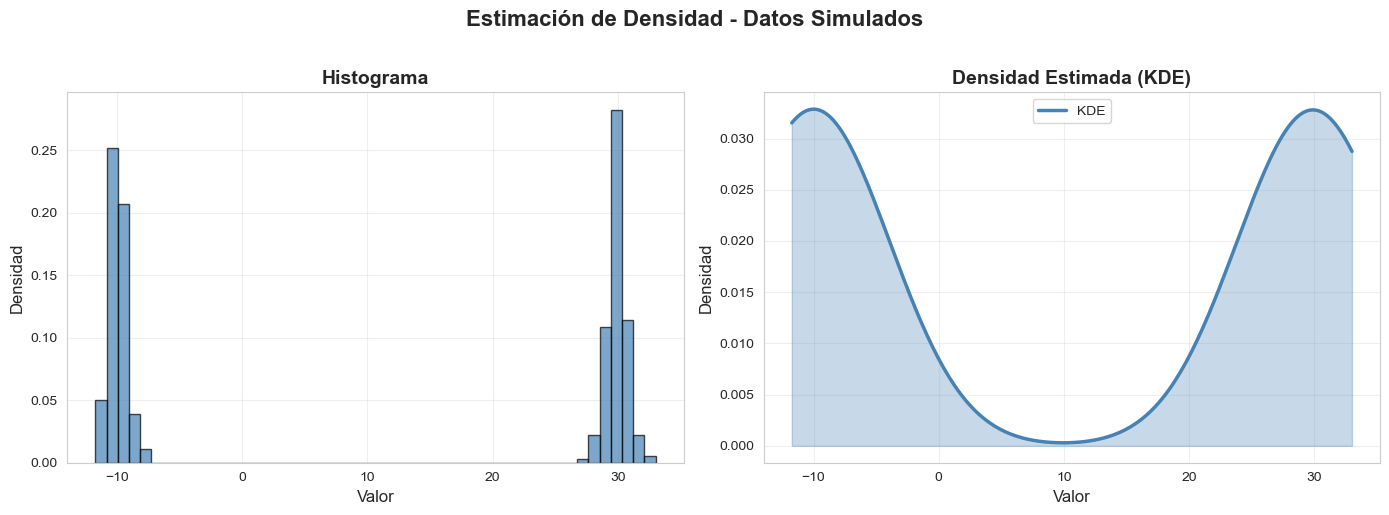

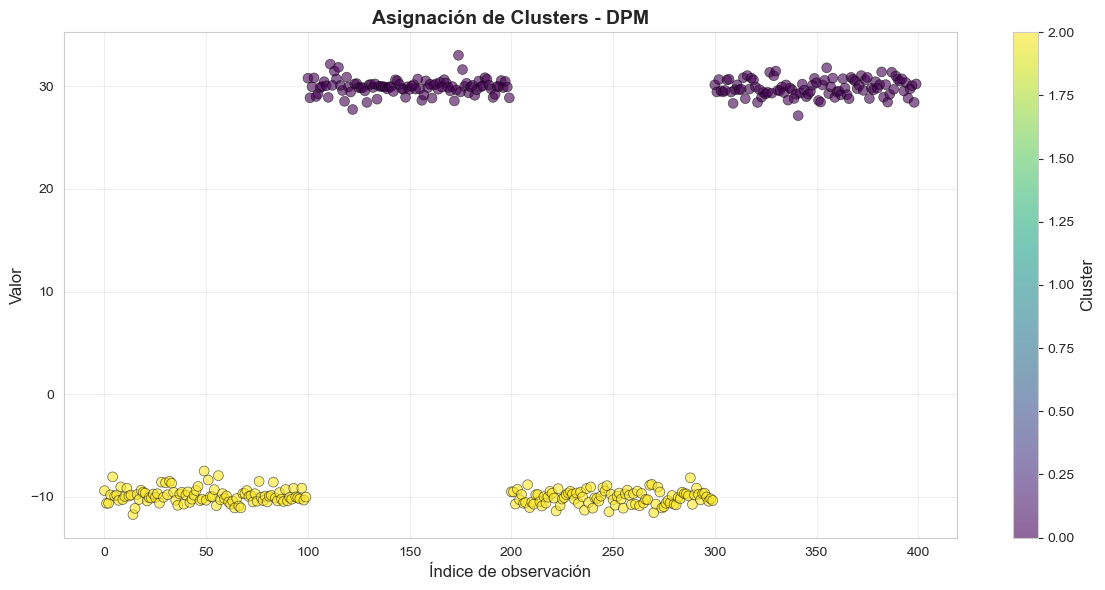

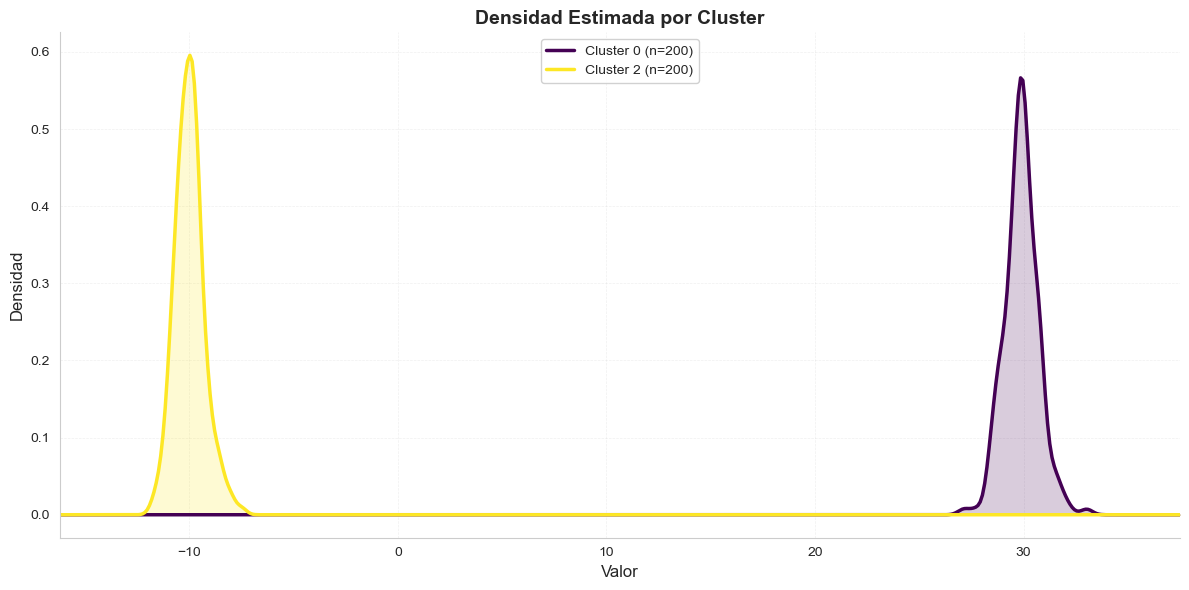

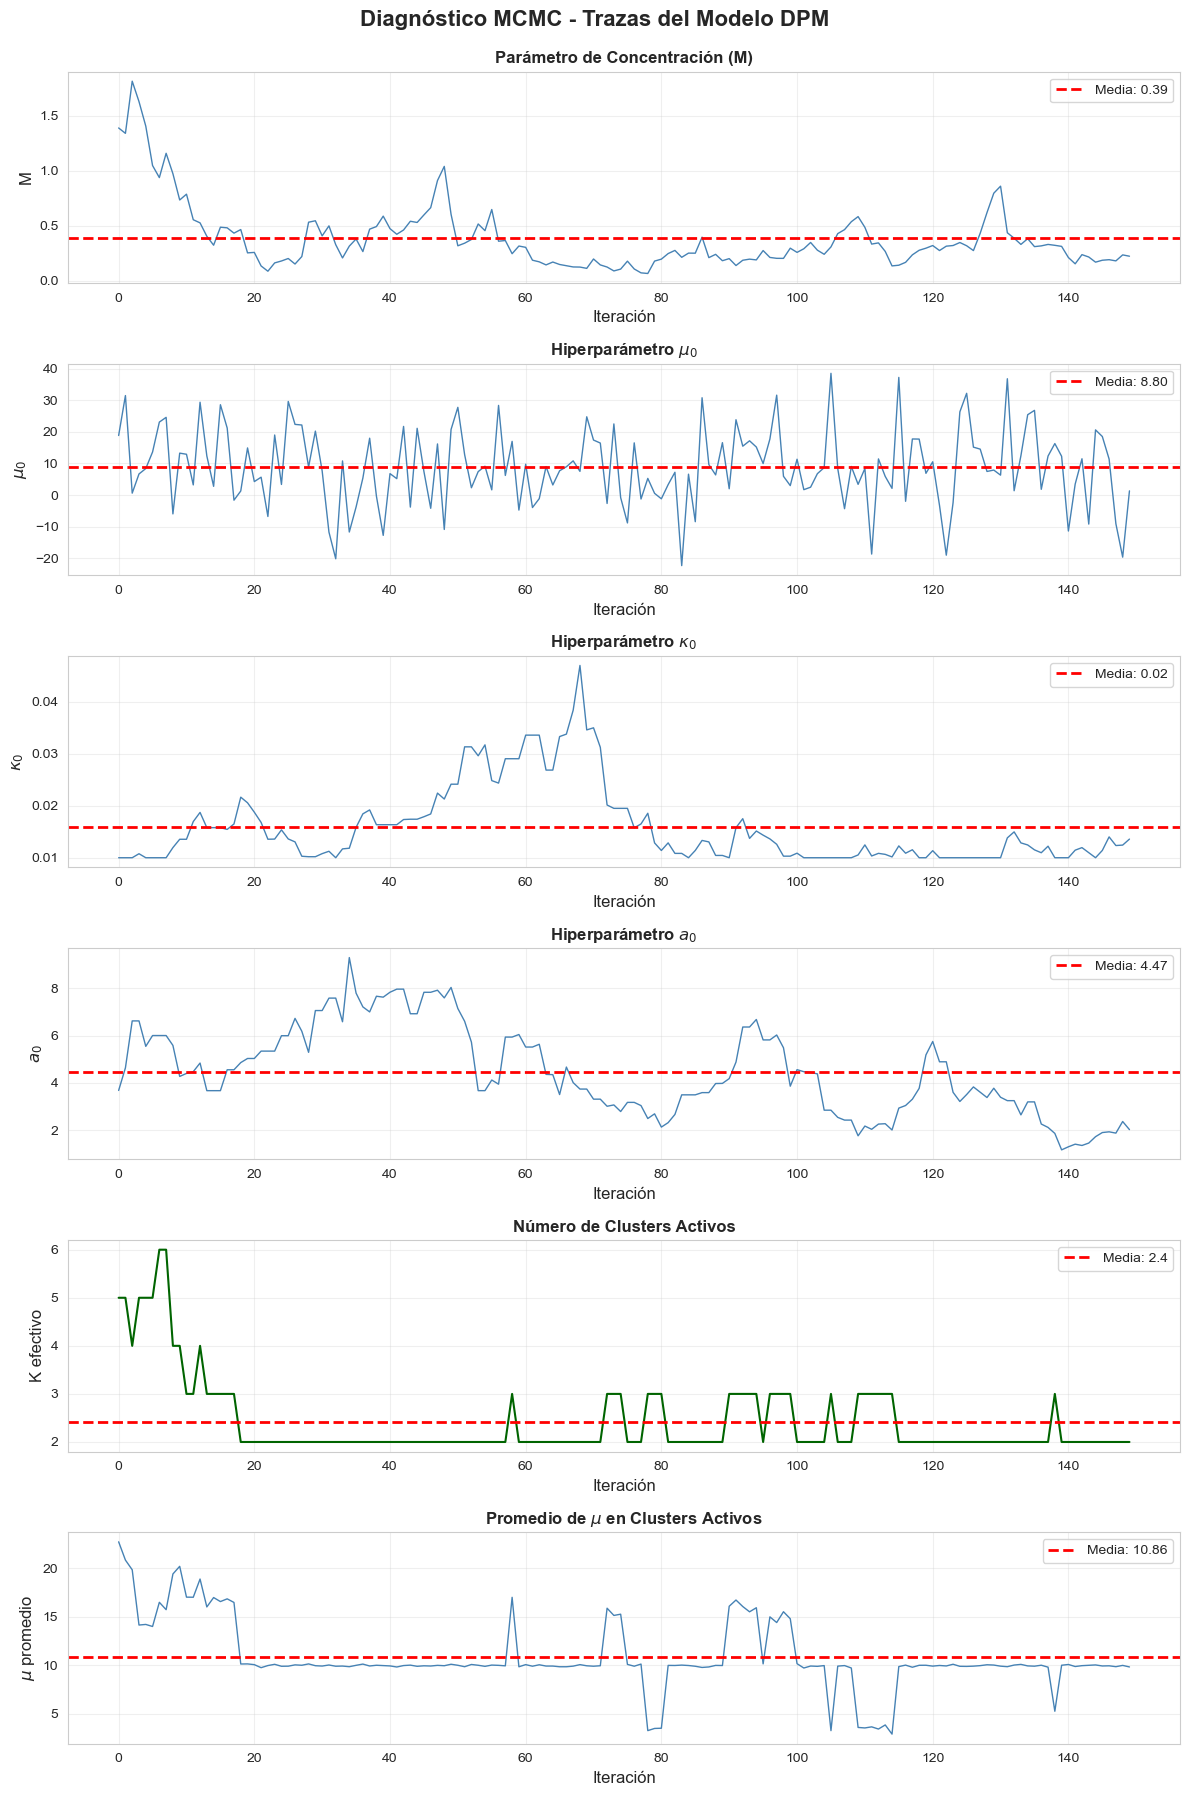

In [6]:
##################################################
# Graficos de diagnostico y analisis
##################################################

# %% 1. Gráfico de Densidad Estimada (Histograma + KDE)
print("\n📊 Generando gráfico de densidad...")
graphics_base_path = get_report_path(config, data_type=SIM_REAL, report_type="graphics")
graphics_path = graphics_base_path / NOMBRE_EJECUCION  # Subcarpeta con nombre de ejecución
graphics_path.mkdir(parents=True, exist_ok=True)

fig1 = plot_density_estimation(
    data=datos['value'].values,
    bins=50,
    title="Estimación de Densidad - Datos Simulados",
    save_path=graphics_path / "density.png"
)

# %% 2. Gráfico de Asignación de Clusters
print("📊 Generando gráfico de asignación de clusters...")
fig2 = plot_cluster_assignment(
    data=datos['value'].values,
    clusters=datos['cluster'].values,
    title="Asignación de Clusters - DPM",
    save_path=graphics_path / "clusters_assignment.png"
)

# %% 3. Gráfico de Densidades por Cluster
print("📊 Generando gráfico de densidades por cluster...")
fig3 = plot_cluster_densities(
    data=datos['value'].values,
    clusters=datos['cluster'].values,
    title="Densidad Estimada por Cluster",
    save_path=graphics_path / "clusters_densities.png"
)

# %% 4. Gráfico de Trazas (Diagnóstico MCMC)
print("📊 Generando gráficos de trazas...")
fig4 = plot_traces(
    trace=trace,
    burn_in=0,  # Ya aplicamos burnin en el modelo
    title="Diagnóstico MCMC - Trazas del Modelo DPM",
    save_path=graphics_path / "traces.png"
)

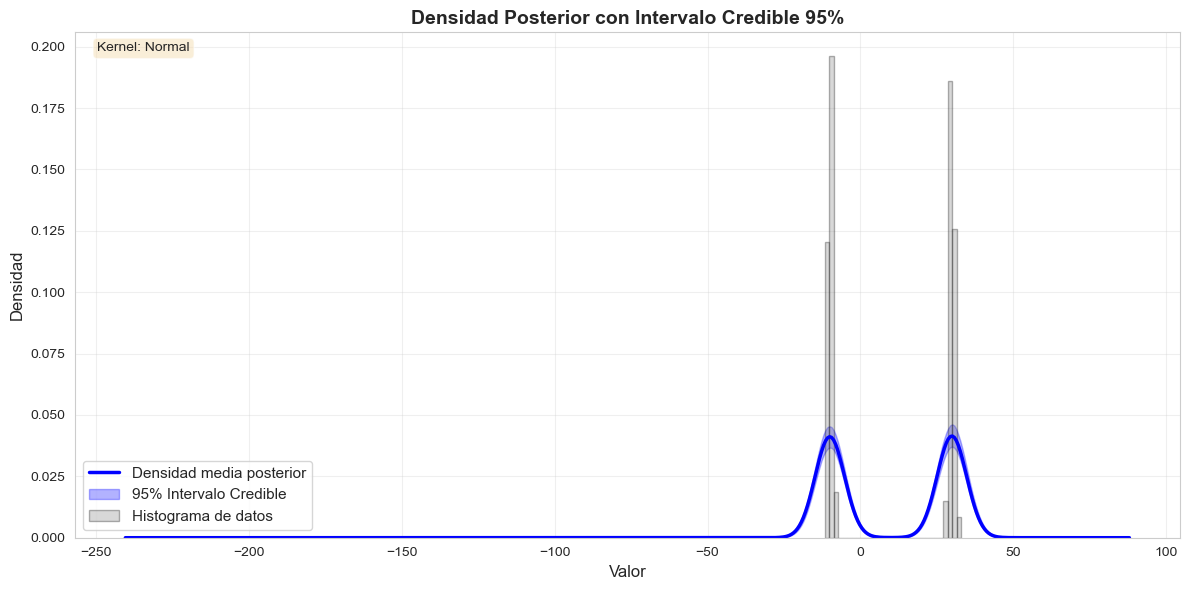

In [7]:
##################################################
# Graficos de intervalo de credibilidad 
##################################################
fig5 = plot_density_credible_interval(
    trace=trace,
    y_data=datos['value'].values,
    kernel='normal',
    burn_in=0,  # Ya aplicamos burnin
    n_posterior=2000,
    title="Densidad Posterior con Intervalo Credible 95%",
    save_path=graphics_path / "credible_interval.png"
)